# 604 Final Project
## How Many Tellers? Simulating Bank Queues to Improve Customer Wait


### by Yina Qiao


### **1. State the problem and its significance.**
This project shows how many bank tellers are needed to make sure customers don’t wait long and the tellers stay busy. This helps the bank run smoothly and makes customers happy.

### **2. Flow-Chart Model**

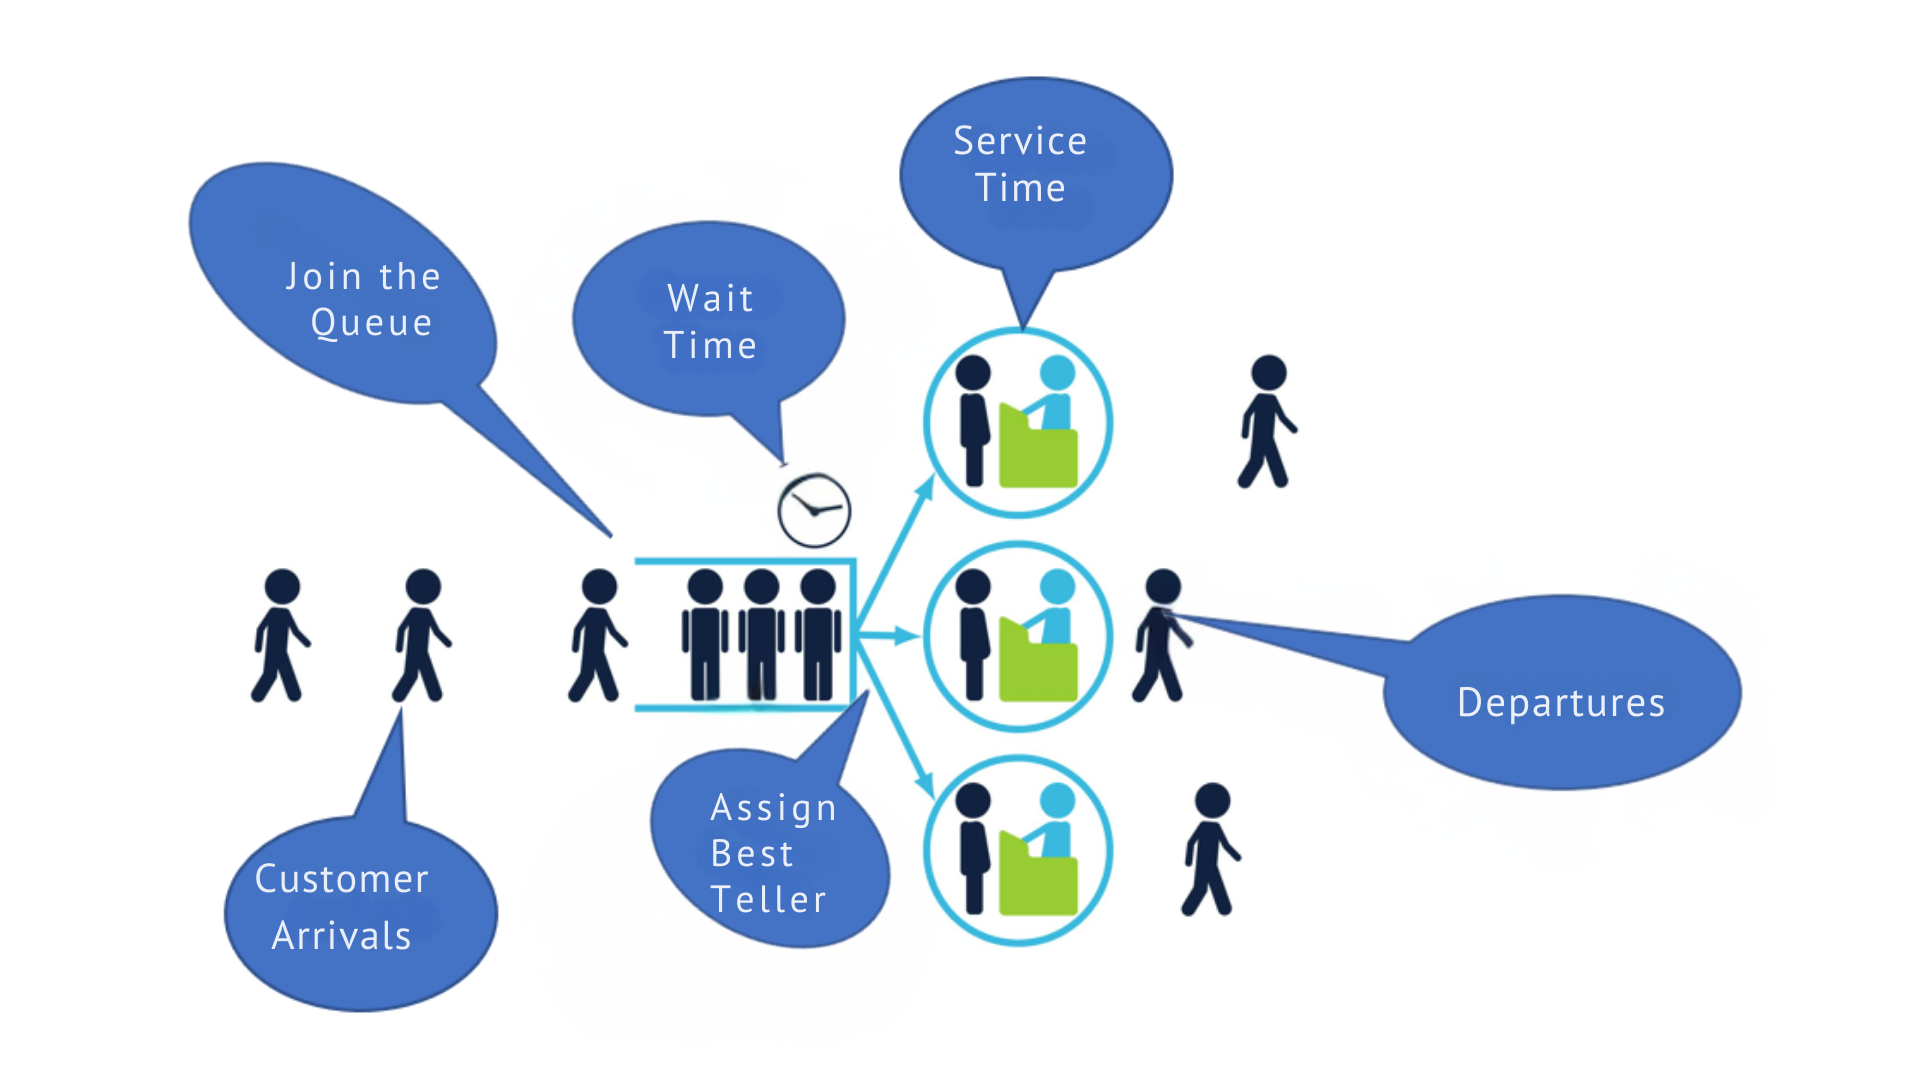

In [1]:
from IPython.display import Image
Image(filename = "flowchart.png", width=600, height=700)

### 3. Simulate the Process

The code simulates 30 days (9 AM to 5 PM) with 1-4 tellers, reflecting real-life staffing limits and revealing performance trends and variations.



**Key Information on Model Design**

- **Arrival Rate:**
  - **Peak Times:** 10 customers per hour (poisson distribution)
  - **Off-Peak Times:** 5 customers per hour (poisson distribution)

- **Service Rate:**
  - 10 customers per hour (exponential distribution)

- **Queue Management:**
  - Individual queues for each teller
  - Customers do not leave the line

- **Simulation Time:**
  - Bank operates from 9 AM to 5 PM
  - Simulation runs for 30 days

- **Metrics Tracked:**
  - Total and served customers
  - Waiting times
  - Teller effective times




### 4. Model Validity and Verification


The model's validity is based on queuing theory principles and domain knowledge from banking. 

Metrics like a 10-minute wait time and 5-hour effective work time for tellers were used. 

Verification steps included:

Code Verification: Ensuring the simulation code correctly models customer arrivals, service times, and queue management.

Multiple Iterations: Running the simulation for 30 days to capture consistent performance data.

Benchmarking: Comparing outputs to expected metrics from industry standards and banking experience.

### 5. Iteration Justification
The simulation was run for 30 days, 9 AM to 5 PM, to capture daily and weekly variations in customer traffic and teller workload. This period ensures a realistic work cycle, identifies patterns, and provides robust data, minimizing short-term anomalies for reliable conclusions and recommendations.

In [2]:
# import and initialization
import numpy as np
import simpy
import matplotlib.pyplot as plt
import datetime as dt
import os

In [3]:
seed = 200
np.random.seed(seed)

In [4]:
# Arrival rates
peak_arrival_rate = 10  # customers per hour during peak times
off_peak_arrival_rate = 5  # customers per hour during off-peak times

In [5]:
# Function to determine if the hour is peak or off-peak
def get_arrival_rate(hour):
    if (11 <= hour < 13) or (15 <= hour < 17):
        return peak_arrival_rate
    else:
        return off_peak_arrival_rate

In [6]:
# Function to generate service time
def generate_service_time(lambda_service):
    return round(np.random.exponential(1 / lambda_service) * 60)

In [7]:
class Metrics:
    def __init__(self, simulation_time: int, tellers: list = []):
        self.total_customers = {'peak': 0, 'off_peak': 0}
        self.served_customers = {'peak': 0, 'off_peak': 0}
        self.waiting_times = {'peak': {}, 'off_peak': {}}
        self.effective_times = {'peak': {}, 'off_peak': {}}
        self.max_waiting_time = {'peak': 0, 'off_peak': 0}
        self.min_waiting_time = {'peak': float('inf'), 'off_peak': float('inf')}
        self.simulation_time = simulation_time
        self.tellers = tellers

    def register_customer(self, period):
        self.total_customers[period] += 1

    def register_served_customer(self, period):
        self.served_customers[period] += 1

    def register_waiting_time(self, teller, waiting_time, period):
        self.max_waiting_time[period] = max(self.max_waiting_time[period], waiting_time)
        self.min_waiting_time[period] = min(self.min_waiting_time[period], waiting_time)
        self.waiting_times[period][teller] = self.waiting_times[period].get(teller, 0) + waiting_time

    def teller_effective_time(self, teller, effective_time, period):
        self.effective_times[period][teller] = self.effective_times[period].get(teller, 0) + effective_time

    def total_waiting_time(self, period):
        return sum(self.waiting_times[period].values())

    def average_waiting_time(self, period):
        return self.total_waiting_time(period) / self.served_customers[period] if self.served_customers[period] else 0

    def total_effective_time(self, period):
        return sum(self.effective_times[period].values())

    def average_effective_time(self, period):
        return self.total_effective_time(period) / len(self.tellers) if self.tellers else 0

    def restart(self):
        self.total_customers = {'peak': 0, 'off_peak': 0}
        self.served_customers = {'peak': 0, 'off_peak': 0}
        self.waiting_times = {'peak': {}, 'off_peak': {}}
        self.effective_times = {'peak': {}, 'off_peak': {}}
        self.max_waiting_time = {'peak': 0, 'off_peak': 0}
        self.min_waiting_time = {'peak': float('inf'), 'off_peak': float('inf')}

In [8]:
# Customer serving process
def desc_minutes(start_time, minutes):
    return (dt.datetime.combine(dt.date.today(), start_time) + dt.timedelta(minutes=minutes)).strftime("%H:%M")

In [9]:
def decide_best_teller(tellers, remaining_times):
    return min(tellers, key=lambda teller: remaining_times[teller])

In [10]:
def get_period(hour):
    return 'peak' if (11 <= hour < 13) or (15 <= hour < 17) else 'off_peak'

In [11]:
def serve_customer(env, customer_id, teller, teller_id, service_time, start_time, metrics_monitor):
    arrival_time = env.now
    current_hour = (start_time.hour + env.now // 60) % 24
    period = get_period(current_hour)
    print(f"Bank customer #{customer_id} arrives at the queue at {desc_minutes(start_time, arrival_time)}")
    
    with teller.request() as request:
        yield request
        service_start_time = env.now
        print(f"Bank customer #{customer_id} is served at teller #{teller_id} at {desc_minutes(start_time, service_start_time)}")
        yield env.timeout(service_time)
        metrics_monitor.teller_effective_time(teller, service_time, period)
        metrics_monitor.register_served_customer(period)
        print(f"Bank customer #{customer_id} finishes being served at {desc_minutes(start_time, env.now)}")
        
        waiting_time = service_start_time - arrival_time
        metrics_monitor.register_waiting_time(teller, waiting_time, period)

In [12]:
def poisson_queue_system(env, arrival_rates, service_rate, tellers, remaining_times, start_time, metrics_monitor):
    customer_id = 0
    while True:
        current_hour = (start_time.hour + env.now // 60) % 24
        period = get_period(current_hour)
        arrival_rate = get_arrival_rate(current_hour)
        for _ in range(np.random.poisson(arrival_rate / 60)):
            customer_id += 1
            metrics_monitor.register_customer(period)
            best_teller = decide_best_teller(tellers, remaining_times)
            service_time = generate_service_time(service_rate / len(tellers))
            remaining_times[best_teller] += service_time
            env.process(serve_customer(env, customer_id, best_teller, tellers.index(best_teller) + 1, service_time, start_time, metrics_monitor))
        yield env.timeout(1)

In [13]:
# Simulation Functions
def poisson_simulate(env, simulation_time, arrival_rates, service_rate, tellers, remaining_times, start_time, metrics_monitor):
    env.process(poisson_queue_system(env, arrival_rates, service_rate, tellers, remaining_times, start_time, metrics_monitor))
    env.run(until=simulation_time)

In [14]:
def run_simulation(env, simulation_time, start_time, n_tellers, arrival_rates, service_rate, metrics_monitor):
    tellers = [simpy.Resource(env, capacity=1) for _ in range(n_tellers)]
    metrics_monitor.tellers = tellers
    remaining_times = {teller: 0 for teller in tellers}

    poisson_simulate(env, simulation_time, arrival_rates, service_rate, tellers, remaining_times, start_time, metrics_monitor)

In [15]:
# Multiple Runs and Plotting
start_time = dt.time(9, 0, 0)  # 9:00 am
end_time = dt.time(17, 0, 0)  # 5:00 pm
simulation_time = (end_time.hour - start_time.hour) * 60  # Simulation time in minutes

Bank customer #1 arrives at the queue at 09:00
Bank customer #1 is served at teller #1 at 09:00
Bank customer #1 finishes being served at 09:05
Bank customer #2 arrives at the queue at 09:07
Bank customer #2 is served at teller #1 at 09:07
Bank customer #3 arrives at the queue at 09:08
Bank customer #4 arrives at the queue at 09:13
Bank customer #5 arrives at the queue at 09:22
Bank customer #6 arrives at the queue at 09:26
Bank customer #2 finishes being served at 09:33
Bank customer #3 is served at teller #1 at 09:33
Bank customer #7 arrives at the queue at 09:34
Bank customer #8 arrives at the queue at 09:37
Bank customer #3 finishes being served at 09:44
Bank customer #4 is served at teller #1 at 09:44
Bank customer #4 finishes being served at 09:48
Bank customer #5 is served at teller #1 at 09:48
Bank customer #9 arrives at the queue at 09:49
Bank customer #5 finishes being served at 09:55
Bank customer #6 is served at teller #1 at 09:55
Bank customer #10 arrives at the queue at 1

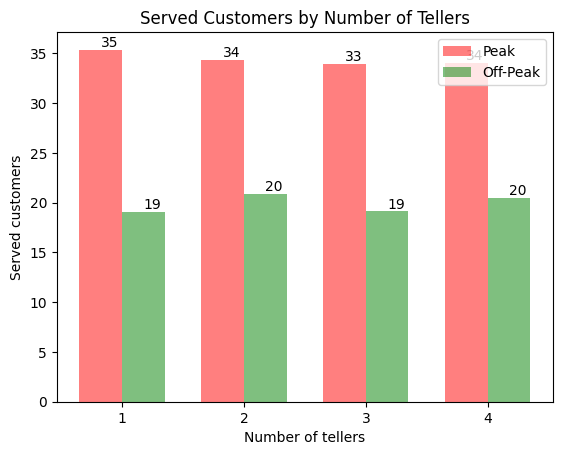

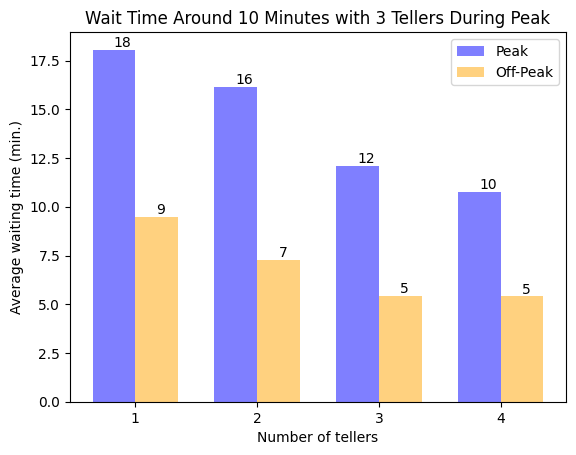

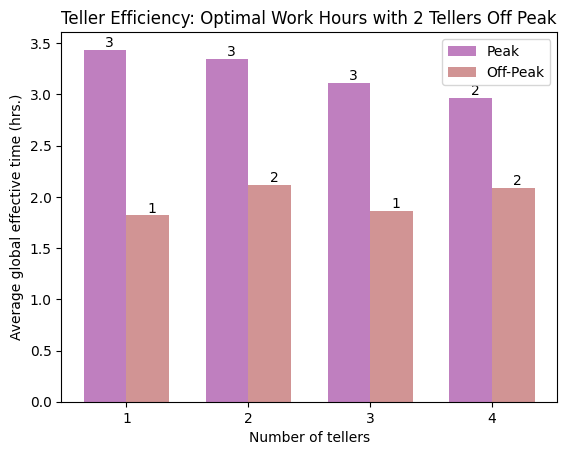

In [16]:
# Multiple Runs and Plotting
n_tellers = [1, 2, 3, 4]
positions = np.arange(len(n_tellers))
bar_width = 0.35

# Initialize storage for results
served_customers_per_teller = {tellers: {'peak': [], 'off_peak': []} for tellers in n_tellers}
average_waiting_times = {tellers: {'peak': [], 'off_peak': []} for tellers in n_tellers}
average_global_effective_times = {tellers: {'peak': [], 'off_peak': []} for tellers in n_tellers}

# Run the simulation for 30 days
days = 30
for day in range(days):
    for n_teller in n_tellers:
        metrics_monitor = Metrics(simulation_time)
        run_simulation(
            env=simpy.Environment(),
            simulation_time=simulation_time,
            start_time=start_time,
            n_tellers=n_teller,
            arrival_rates=(peak_arrival_rate, off_peak_arrival_rate),
            service_rate=10,
            metrics_monitor=metrics_monitor,
        )
        for period in ['peak', 'off_peak']:
            served_customers_per_teller[n_teller][period].append(metrics_monitor.served_customers[period])
            average_waiting_times[n_teller][period].append(metrics_monitor.average_waiting_time(period))
            average_global_effective_times[n_teller][period].append(metrics_monitor.average_effective_time(period) / 60)
        metrics_monitor.restart()

# Calculate averages for plotting
average_served_customers = {tellers: {period: np.mean(served_customers_per_teller[tellers][period]) for period in ['peak', 'off_peak']} for tellers in n_tellers}
average_waiting_times = {tellers: {period: np.mean(average_waiting_times[tellers][period]) for period in ['peak', 'off_peak']} for tellers in n_tellers}
average_effective_times = {tellers: {period: np.mean(average_global_effective_times[tellers][period]) for period in ['peak', 'off_peak']} for tellers in n_tellers}

# Plot results
variables_to_plot = [
    ("Served customers", average_served_customers),
    ("Average waiting time (min.)", average_waiting_times),
    ("Average global effective time (hrs.)", average_effective_times),
]

titles = [
    "Served Customers by Number of Tellers",
    "Wait Time Around 10 Minutes with 3 Tellers During Peak",
    "Teller Efficiency: Optimal Work Hours with 2 Tellers Off Peak"
]

def colors():
    yield from ["red", "green", "blue", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"]

colors_gen = colors()

for i, (desc, arg_dict) in enumerate(variables_to_plot):
    peak_values = [arg_dict[tellers]['peak'] for tellers in n_tellers]
    off_peak_values = [arg_dict[tellers]['off_peak'] for tellers in n_tellers]
    
    fig, ax = plt.subplots()
    bars1 = ax.bar(positions - bar_width/2, peak_values, align="center", alpha=0.5, color=next(colors_gen), width=bar_width, label='Peak')
    bars2 = ax.bar(positions + bar_width/2, off_peak_values, align="center", alpha=0.5, color=next(colors_gen), width=bar_width, label='Off-Peak')
    
    for bar in bars1:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment
    
    for bar in bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')
    
    plt.xticks(positions, n_tellers)
    plt.xlabel("Number of tellers")
    plt.ylabel(f"{desc}")
    plt.title(titles[i])
    plt.legend()
    plt.show()


### Conclusions/Findings

Recommended: Optimal teller numbers: 3 during peak hours, 2 during off-peak hours, cross-train staff as needed

Further research could include analyzing customer satisfaction (OSAT score) and running more realistic iterations for 6 months, taking holidays into account.
